In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder, OrdinalEncoder

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# Se carga el dataset de trabajo y se comprueba la información general
path = ("../data/weather_classification_data.csv")
df = pd.read_csv(path, delimiter = ",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [3]:
# Se eliminan los espacios en los nombres de las columnas
df.rename(columns = {"Wind Speed": "Wind_Speed", "Precipitation (%)": "Precipitation", "Cloud Cover": "Cloud_Cover", "Atmospheric Pressure":"Atm_Press", "Visibility (km)":"Visibility", "UV Index":"UV_I", "Weather Type":"Weather_Type"}, inplace = True)
df.columns

Index(['Temperature', 'Humidity', 'Wind_Speed', 'Precipitation', 'Cloud_Cover',
       'Atm_Press', 'UV_I', 'Season', 'Visibility', 'Location',
       'Weather_Type'],
      dtype='object')

In [4]:
# Se identifica la variable objetivo y se separan los subconjuntos train/test
target = "Weather_Type"
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

In [5]:
train_set.Weather_Type.value_counts()

Weather_Type
Sunny     2659
Rainy     2653
Cloudy    2649
Snowy     2599
Name: count, dtype: int64

In [6]:
# Se codifican los valores del target
categories = [["Sunny","Cloudy","Rainy","Snowy"]]
encoder = OrdinalEncoder(categories = categories)
train_set[target] = encoder.fit_transform(train_set[[target]])
test_set[target] = encoder.fit_transform(test_set[[target]])

In [7]:
# Se separan los subconjuntos X,y
X_train = train_set.copy()
X_train.drop(columns = target, inplace = True)
y_train = train_set[target]

X_test = test_set.copy()
X_test.drop(columns = target, inplace = True)
y_test = test_set[target]

In [8]:
lista_cat = ["Cloud_Cover","Season","Location","UV_I"]
lista_num = ["Temperature","Humidity","Wind_Speed","Precipitation","Atm_Press","Visibility"]
print(lista_cat)
print(lista_num)

['Cloud_Cover', 'Season', 'Location', 'UV_I']
['Temperature', 'Humidity', 'Wind_Speed', 'Precipitation', 'Atm_Press', 'Visibility']


### MODIFICACIONES

In [9]:
# Preprocesado de variables con Pipeline

# Primer nivel - Imputar median o moda a posibles valores faltantes
# Segundo nivel - Aplicar OneHotEncoding a las variables categóricas
# Tercer nivel - Aplicar modificación de raiz cuadrada y MinMaxScaler a las variables numéricas

target = target
lista_cat = lista_cat
lista_num = lista_num
lista_cat_str = ["Cloud_Cover","Season","Location"]
lista_cat_num = ["UV_I"]
lista_num_Ssqrt = ["Temperature","Wind_Speed","Visibility"]
lista_num_Nsqrt = ["Humidity","Precipitation","Atm_Press"]

cat_pipeline_num = Pipeline(
    [("Impute_Median", SimpleImputer(strategy = "median")),
     ("OHEncoder", OneHotEncoder())])

cat_pipeline = Pipeline(
    [("Impute_Mode", SimpleImputer(strategy = "most_frequent")),
     ("OHEncoder", OneHotEncoder())])

num_pipeline_sqrt = Pipeline(
    [("Impute_Median", SimpleImputer(strategy = "median")),
     ("Apply_SquareRoot", FunctionTransformer(np.sqrt, feature_names_out='one-to-one')),
     ("MMScaler", MinMaxScaler())])

num_pipeline = Pipeline(
    [("Impute_Median", SimpleImputer(strategy = "median")),
     ("MMcaler", MinMaxScaler())])

preprocessing = ColumnTransformer(
    [("Process_Categorical", cat_pipeline, lista_cat_str), 
    ("Process_Categorical_num", cat_pipeline, lista_cat_num), 
    ("Process_Numeric_sqrt", num_pipeline_sqrt, lista_num_Ssqrt),
    ("Process_Numeric", num_pipeline, lista_num_Nsqrt)],     
     remainder = "passthrough")

In [10]:
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('Process_Categorical',
                                 Pipeline(steps=[('Impute_Mode',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('OHEncoder',
                                                  OneHotEncoder())]),
                                 ['Cloud_Cover', 'Season', 'Location']),
                                ('Process_Categorical_num',
                                 Pipeline(steps=[('Impute_Mode',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('OHEncoder',
                                                  OneHotEncoder())])...
                                                  SimpleImputer(strategy='median')),
                                                 ('Apply_SquareRoot',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'sqrt'>)),
                                                 ('MMScaler', MinMaxScaler())]),
                                 ['Temperature', 'Wind_Speed', 'Visibility']),
                                ('Process_Numeric',
                                 Pipeline(steps=[('Impute_Median',
                                                  SimpleImputer(strategy='median')),
                                                 ('MMcaler', MinMaxScaler())]),
                                 ['Humidity', 'Precipitation', 'Atm_Press'])])

### BASELINE

In [11]:
# Modelado con Pipeline
random_pipeline = Pipeline(
    [("Preprocesado", preprocessing),
     ("Modelo", RandomForestClassifier(random_state = 42))])

xgb_pipeline = Pipeline(
    [("Preprocesado", preprocessing),
     ("Modelo", XGBClassifier(random_state = 42))])

for name, pipe in zip(["randomF", "XGB"],[random_pipeline, xgb_pipeline]):
    resultado = cross_val_score(pipe, X_train, y_train, cv = 5, scoring = "accuracy")
    print(f"{name}: {np.mean(resultado):.4f}")
    print(resultado)

s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:387: RuntimeWarning: invalid value encountered in sqrt
  return func(X, **(kw_args if kw_args else {}))
s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:387: RuntimeWarning: invalid value encountered in sqrt
  return func(X, **(kw_args if kw_args else {}))
s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:387: RuntimeWarning: invalid value encountered in sqrt
  return func(X, **(kw_args if kw_args else {}))
s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:387: RuntimeWarning: invalid value encountered in sqrt
  return func(X, **(kw_args if kw_args else {}))
s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\s

randomF: 0.9164
[0.91382576 0.91429924 0.91098485 0.92092803 0.921875  ]


s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:387: RuntimeWarning: invalid value encountered in sqrt
  return func(X, **(kw_args if kw_args else {}))
s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:387: RuntimeWarning: invalid value encountered in sqrt
  return func(X, **(kw_args if kw_args else {}))
s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:387: RuntimeWarning: invalid value encountered in sqrt
  return func(X, **(kw_args if kw_args else {}))
s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:387: RuntimeWarning: invalid value encountered in sqrt
  return func(X, **(kw_args if kw_args else {}))
s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\s

XGB: 0.9117
[0.91524621 0.90767045 0.90482955 0.91524621 0.9157197 ]


s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:387: RuntimeWarning: invalid value encountered in sqrt
  return func(X, **(kw_args if kw_args else {}))


### OPTIMIZACIÓN DE PARÁMETROS

In [12]:
# Se busca el mejor ajuste para RandomForest
pipe_rand_forest_param = {
    "Modelo__n_estimators": [50,100,200,400,800],
    "Modelo__max_depth": [None,1,2,4,8,16],
    "Modelo__max_features": [None,"sqrt","log2"],
    "Modelo__class_weight": ["balanced", None]}

gs_rand_forest = GridSearchCV(random_pipeline,
                              pipe_rand_forest_param,
                              cv = 5,
                              scoring = "accuracy",
                              verbose = 1,
                              n_jobs = -1)

In [13]:
gs_rand_forest.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:387: RuntimeWarning: invalid value encountered in sqrt
  return func(X, **(kw_args if kw_args else {}))


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Process_Categorical',
                                                                         Pipeline(steps=[('Impute_Mode',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('OHEncoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Cloud_Cover',
                                                                          'Season',
                                                                          'Location']),
                                                                        ('Process_Categorical_num',
                                                                         Pipeline(steps=[('Impute_Mode',
                                                                                          SimpleImpute...
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('MMcaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Humidity',
                                                                          'Precipitation',
                                                                          'Atm_Press'])])),
                                       ('Modelo',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'Modelo__class_weight': ['balanced', None],
                         'Modelo__max_depth': [None, 1, 2, 4, 8, 16],
                         'Modelo__max_features': [None, 'sqrt', 'log2'],
                         'Modelo__n_estimators': [50, 100, 200, 400, 800]},
             scoring='accuracy', verbose=1)

In [14]:
# Se determina el mejor modelo con el resultado del GridSearch
gs_rand_forest.best_params_

{'Modelo__class_weight': None,
 'Modelo__max_depth': None,
 'Modelo__max_features': 'sqrt',
 'Modelo__n_estimators': 400}

In [15]:
gs_rand_forest

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Process_Categorical',
                                                                         Pipeline(steps=[('Impute_Mode',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('OHEncoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Cloud_Cover',
                                                                          'Season',
                                                                          'Location']),
                                                                        ('Process_Categorical_num',
                                                                         Pipeline(steps=[('Impute_Mode',
                                                                                          SimpleImpute...
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('MMcaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Humidity',
                                                                          'Precipitation',
                                                                          'Atm_Press'])])),
                                       ('Modelo',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'Modelo__class_weight': ['balanced', None],
                         'Modelo__max_depth': [None, 1, 2, 4, 8, 16],
                         'Modelo__max_features': [None, 'sqrt', 'log2'],
                         'Modelo__n_estimators': [50, 100, 200, 400, 800]},
             scoring='accuracy', verbose=1)

### GUARDADO DE MODELO

In [16]:
# Mediante pickle
with open("../modelo_clasificador.pkl", "wb") as archivo:
    pickle.dump(gs_rand_forest, archivo)

### EVALUACIÓN DEL MODELO

In [17]:
# Recuperamos el modelo de Pipeline
with open("../modelo_clasificador.pkl", "rb") as archivo:
    modelo = pickle.load(archivo)

In [18]:
modelo.best_params_

{'Modelo__class_weight': None,
 'Modelo__max_depth': None,
 'Modelo__max_features': 'sqrt',
 'Modelo__n_estimators': 400}

In [19]:
modelo

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Process_Categorical',
                                                                         Pipeline(steps=[('Impute_Mode',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('OHEncoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Cloud_Cover',
                                                                          'Season',
                                                                          'Location']),
                                                                        ('Process_Categorical_num',
                                                                         Pipeline(steps=[('Impute_Mode',
                                                                                          SimpleImpute...
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('MMcaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Humidity',
                                                                          'Precipitation',
                                                                          'Atm_Press'])])),
                                       ('Modelo',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'Modelo__class_weight': ['balanced', None],
                         'Modelo__max_depth': [None, 1, 2, 4, 8, 16],
                         'Modelo__max_features': [None, 'sqrt', 'log2'],
                         'Modelo__n_estimators': [50, 100, 200, 400, 800]},
             scoring='accuracy', verbose=1)

In [20]:
X_test.columns

Index(['Temperature', 'Humidity', 'Wind_Speed', 'Precipitation', 'Cloud_Cover',
       'Atm_Press', 'UV_I', 'Season', 'Visibility', 'Location'],
      dtype='object')

In [21]:
# # Comprobación de funcionamiento
# pipe_test = preprocessing.fit_transform(X_test)
# df_pipe_test = pd.DataFrame(pipe_train, columns = preprocessing.get_feature_names_out())
# df_pipe_test.describe().T

In [22]:
modelo.predict(X_test)

s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:387: RuntimeWarning: invalid value encountered in sqrt
  return func(X, **(kw_args if kw_args else {}))


array([0., 0., 0., ..., 3., 3., 1.])

s:\Users\NewWalhalla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:387: RuntimeWarning: invalid value encountered in sqrt
  return func(X, **(kw_args if kw_args else {}))


              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93       641
         1.0       0.87      0.90      0.89       651
         2.0       0.90      0.92      0.91       647
         3.0       0.96      0.95      0.95       701

    accuracy                           0.92      2640
   macro avg       0.92      0.92      0.92      2640
weighted avg       0.92      0.92      0.92      2640



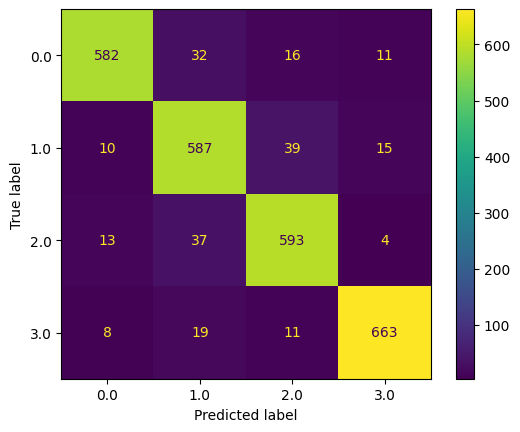

In [23]:
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);